In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install surprise

     |████████████████████████████████| 11.8 MB 4.5 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619413 sha256=0c85616243253544f0d91c38c0cfdba19997a7c507555adea79d6bd5f664cd67
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [3]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import os
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error


import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV


In [4]:
df = pd.read_csv("/content/drive/MyDrive/NetflixProject/Netflix/archive/NetflixRatings.csv", sep=",", names = ["MovieID","CustID", "Ratings", "Date"])
df["Date"] = pd.to_datetime(df["Date"])
df_movie=pd.read_csv('/content/drive/MyDrive/Netflix/Data/additions/updated_movie_titles.csv')


In [5]:
df.head()

,MovieID,CustID,Ratings,Date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


In [6]:
df_movie.head()

,ID,Year,Name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [7]:
df_movie.tail()

,ID,Year,Name
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004.0,Fidel Castro: American Experience
17767,17768,2000.0,Epoch
17768,17769,2003.0,The Company
17769,17770,2003.0,Alien Hunter


In [8]:
df.shape

(100480507, 4)

In [9]:
df_movie.shape

(17770, 3)

In [10]:
df_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      17770 non-null  int64  
 1   Year    17763 non-null  float64
 2   Name    17770 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 416.6+ KB


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100480507 entries, 0 to 100480506
Data columns (total 4 columns):
 #   Column   Dtype         
---  ------   -----         
 0   MovieID  int64         
 1   CustID   int64         
 2   Ratings  int64         
 3   Date     datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 3.0 GB


In [12]:
df.isnull().sum()

MovieID    0
CustID     0
Ratings    0
Date       0
dtype: int64

In [13]:
df_movie.isnull().sum()

ID      0
Year    7
Name    0
dtype: int64

In [14]:
df_movie[df_movie['Year'].isnull()]

,ID,Year,Name
4387,4388,NaN,Ancient Civilizations: Rome and Pompeii
4793,4794,NaN,Ancient Civilizations: Land of the Pharaohs
7240,7241,NaN,Ancient Civilizations: Athens and Greece
10781,10782,NaN,Roti Kapada Aur Makaan
15917,15918,NaN,Hote Hote Pyaar Ho Gaya
16677,16678,NaN,Jimmy Hollywood
17666,17667,NaN,Eros Dance Dhamaka


In [15]:
ID_values=df_movie[df_movie['Year'].isnull()].ID.values
ID_values

array([ 4388,  4794,  7241, 10782, 15918, 16678, 17667])

In [16]:
years=[]
for i in ID_values:
  temp=df[df['MovieID']==i].sort_values('Date').iloc[0]
  years.append(temp.Date.year)
  
years

[2001, 2001, 2001, 2000, 2000, 2004, 2000]

In [17]:
temp1=df_movie[df_movie['Year'].isnull()]
temp1

,ID,Year,Name
4387,4388,NaN,Ancient Civilizations: Rome and Pompeii
4793,4794,NaN,Ancient Civilizations: Land of the Pharaohs
7240,7241,NaN,Ancient Civilizations: Athens and Greece
10781,10782,NaN,Roti Kapada Aur Makaan
15917,15918,NaN,Hote Hote Pyaar Ho Gaya
16677,16678,NaN,Jimmy Hollywood
17666,17667,NaN,Eros Dance Dhamaka


In [18]:
count=0
for i in years:
  temp1.Year.values[count]=i
  count=count+1
temp1  

,ID,Year,Name
4387,4388,2001.0,Ancient Civilizations: Rome and Pompeii
4793,4794,2001.0,Ancient Civilizations: Land of the Pharaohs
7240,7241,2001.0,Ancient Civilizations: Athens and Greece
10781,10782,2000.0,Roti Kapada Aur Makaan
15917,15918,2000.0,Hote Hote Pyaar Ho Gaya
16677,16678,2004.0,Jimmy Hollywood
17666,17667,2000.0,Eros Dance Dhamaka


In [19]:
df_movie.dropna(inplace=True)

In [20]:
df_movie=pd.concat([df_movie,temp1])


In [21]:
df_movie.tail(10)

,ID,Year,Name
17767,17768,2000.0,Epoch
17768,17769,2003.0,The Company
17769,17770,2003.0,Alien Hunter
4387,4388,2001.0,Ancient Civilizations: Rome and Pompeii
4793,4794,2001.0,Ancient Civilizations: Land of the Pharaohs
7240,7241,2001.0,Ancient Civilizations: Athens and Greece
10781,10782,2000.0,Roti Kapada Aur Makaan
15917,15918,2000.0,Hote Hote Pyaar Ho Gaya
16677,16678,2004.0,Jimmy Hollywood
17666,17667,2000.0,Eros Dance Dhamaka


In [22]:
df_movie.sort_index(inplace=True)

In [23]:
df_movie.shape

(17770, 3)

In [24]:
df_movie.isnull().sum()

ID      0
Year    0
Name    0
dtype: int64

In [25]:
df_movie.tail()

,ID,Year,Name
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004.0,Fidel Castro: American Experience
17767,17768,2000.0,Epoch
17768,17769,2003.0,The Company
17769,17770,2003.0,Alien Hunter


In [26]:
df_movie[df_movie['Year'].isnull()]

,ID,Year,Name


In [27]:
df_movie.rename(columns = {'ID':'MovieID'}, inplace = True)

In [28]:
df.duplicated(["MovieID","CustID", "Ratings"]).sum()

0

In [29]:
dfnew=df.copy()

In [30]:
dfnew=dfnew.merge(df_movie,on='MovieID')
dfnew.head()

,MovieID,CustID,Ratings,Date,Year,Name
0,1,1488844,3,2005-09-06,2003.0,Dinosaur Planet
1,1,822109,5,2005-05-13,2003.0,Dinosaur Planet
2,1,885013,4,2005-10-19,2003.0,Dinosaur Planet
3,1,30878,4,2005-12-26,2003.0,Dinosaur Planet
4,1,823519,3,2004-05-03,2003.0,Dinosaur Planet


In [31]:
print("Total number of movie ratings = "+str(df.shape[0]))
print("Number of unique users = "+str(len(np.unique(dfnew["CustID"]))))
print("Number of unique movies = "+str(len(np.unique(dfnew["MovieID"]))))
print("Number of unique Movie Names = "+str(len(np.unique(dfnew["Name"]))))

Total number of movie ratings = 100480507
Number of unique users = 480189
Number of unique movies = 17770
Number of unique Movie Names = 17359


In [32]:
dfnew.describe(include='all')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,MovieID,CustID,Ratings,Date,Year,Name
count,1.004805e+08,1.004805e+08,1.004805e+08,100480507,1.004805e+08,100480507
unique,NaN,NaN,NaN,2182,NaN,17359
top,NaN,NaN,NaN,2005-01-19 00:00:00,NaN,Miss Congeniality
freq,NaN,NaN,NaN,737570,NaN,232944
first,NaN,NaN,NaN,1999-11-11 00:00:00,NaN,NaN
last,NaN,NaN,NaN,2005-12-31 00:00:00,NaN,NaN
mean,9.070915e+03,1.322489e+06,3.604290e+00,NaN,1.993912e+03,NaN
std,5.131891e+03,7.645368e+05,1.085219e+00,NaN,1.240079e+01,NaN
min,1.000000e+00,6.000000e+00,1.000000e+00,NaN,1.896000e+03,NaN
25%,4.677000e+03,6.611980e+05,3.000000e+00,NaN,1.990000e+03,NaN


In [33]:
dfnew.groupby(['Name']).mean()['Ratings'].sort_values(ascending=False)

Name
Lord of the Rings: The Return of the King: Extended Edition            4.723270
The Lord of the Rings: The Fellowship of the Ring: Extended Edition    4.716611
Lord of the Rings: The Two Towers: Extended Edition                    4.702611
Lost: Season 1                                                         4.670989
Battlestar Galactica: Season 1                                         4.638809
                                                                         ...   
The Worst Horror Movie Ever Made                                       1.400000
Vampire Assassins                                                      1.396761
Alone in a Haunted House                                               1.375610
Zodiac Killer                                                          1.346021
Avia Vampire Hunter                                                    1.287879
Name: Ratings, Length: 17359, dtype: float64

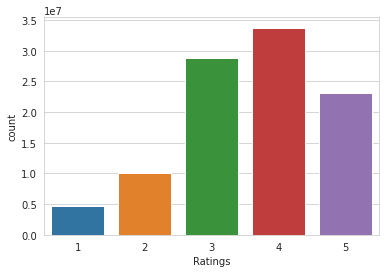

In [34]:
sns.countplot(x="Ratings", data=df)

In [35]:
dfnew.groupby(['Name']).count()['Ratings'].sort_values(ascending=False)

Name
Miss Congeniality                                         232944
Independence Day                                          216596
The Patriot                                               211764
The Day After Tomorrow                                    196397
Pirates of the Caribbean: The Curse of the Black Pearl    193941
                                                           ...  
Dune: Extended Edition                                        13
Larryboy and the Rumor Weed                                   10
Hockey Mom                                                    10
The Land Before Time IV: Journey Through the Mists             5
Mobsters and Mormons                                           3
Name: Ratings, Length: 17359, dtype: int64

In [36]:
MovieCount=dfnew.groupby(['Name']).count()['Ratings'].sort_values(ascending=False)
MeanRatings=dfnew.groupby(['Name']).mean()['Ratings'].sort_values(ascending=False)
Ratings=pd.concat([MovieCount,MeanRatings],axis=1)
Ratings.columns=['No. of Ratings','Avg. Rating']
Ratings.head()

,No. of Ratings,Avg. Rating
Miss Congeniality,232944,3.361267
Independence Day,216596,3.724238
The Patriot,211764,3.747955
The Day After Tomorrow,196397,3.442166
Pirates of the Caribbean: The Curse of the Black Pearl,193941,4.153908


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff08097b910>,
      dtype=object)

<Figure size 1440x1440 with 0 Axes>

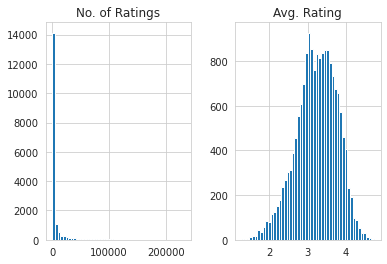

In [37]:
plt.figure(figsize=(20,20))
#plt.hist(x='Avg. Rating',y='No. of Ratings',data=Ratings,bins=50)
Ratings.hist(bins=50)


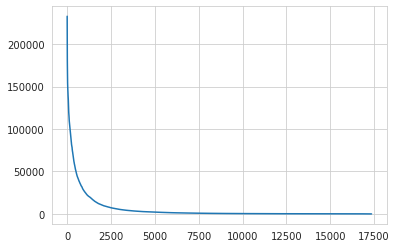

In [38]:
plt.plot(Ratings['No. of Ratings'].values)

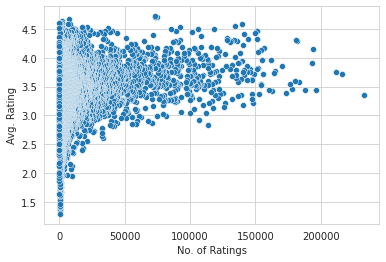

In [39]:
sns.scatterplot(y='Avg. Rating',x='No. of Ratings',data=Ratings)

In [40]:
dfnew['WatchedYear']=pd.DatetimeIndex(df['Date']).year
dfnew.head()

,MovieID,CustID,Ratings,Date,Year,Name,WatchedYear
0,1,1488844,3,2005-09-06,2003.0,Dinosaur Planet,2005
1,1,822109,5,2005-05-13,2003.0,Dinosaur Planet,2005
2,1,885013,4,2005-10-19,2003.0,Dinosaur Planet,2005
3,1,30878,4,2005-12-26,2003.0,Dinosaur Planet,2005
4,1,823519,3,2004-05-03,2003.0,Dinosaur Planet,2004


In [41]:
dfnew['WatchedYear'].value_counts()

2005    53250073
2004    30206574
2003     9985337
2002     4342871
2001     1769031
2000      924443
1999        2178
Name: WatchedYear, dtype: int64

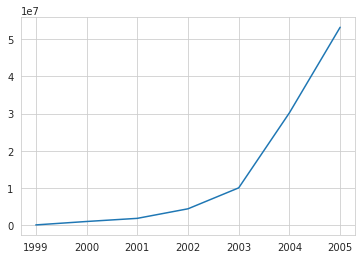

In [42]:
dfnew['WatchedYear'].value_counts().plot()

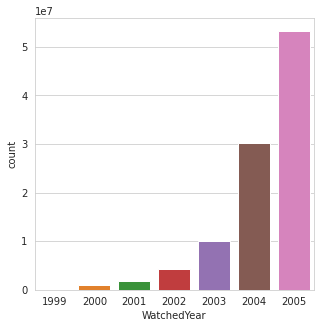

In [43]:
plt.figure(figsize=(5,5))
sns.countplot(data=dfnew,x='WatchedYear')

In [44]:
CustCount=dfnew.groupby(['CustID']).count()['Ratings'].sort_values(ascending=False)
CustRatingsMean=dfnew.groupby(['CustID']).mean()['Ratings'].sort_values(ascending=False)
CustRatings=pd.concat([CustCount,CustRatingsMean],axis=1)
CustRatings.columns=['No. of Ratings','Avg. Rating']
CustRatings.sort_values(by='No. of Ratings',inplace=True,ascending=False)
CustRatings.head()

,No. of Ratings,Avg. Rating
CustID,,
305344,17653,1.908174
387418,17436,1.809073
2439493,16565,1.216843
1664010,15813,4.264339
2118461,14831,4.082328


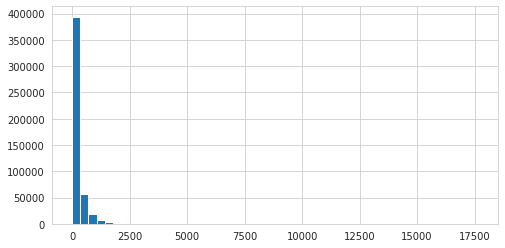

In [45]:
plt.figure(figsize=(8,4))
#plt.hist(x='Avg. Rating',y='No. of Ratings',data=Ratings,bins=50)
CustCount.hist(bins=50)

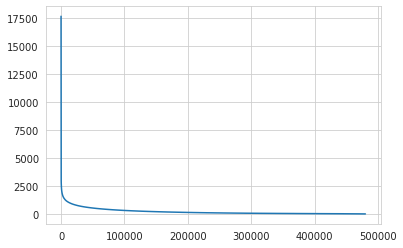

In [46]:
plt.plot(CustCount.values)